<a href="https://colab.research.google.com/github/bmnds/uea-data-science-03-statistics/blob/main/%5BEstat%C3%ADstica04%5D_Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final da Disciplina de Estatística do Curso de Pós-Graduação em Ciência de Dados da UEA-AM
**Grupo:** Alberto, Bruno, Lelson e Levi

## O Trabalho
* Definir um tema e os objetivos a serem analisados 
* Escolher um dataframe com no mínimo cinco campos e 25 linhas, dos quais pelo menos dois devem ser numéricos
* Realizar um levantamento amostral atendendo a todos os critérios de avaliação

## A Avaliação
1. [ ] Construir tabelas e gráficos apropriados para cada variável do data frame
2. [ ] Calcular a média, mediana, moda, desvio-padrão, coeficiente de variação
e simetria das variáveis quantitativas
3. [ ] Analisar a normalidade dos dados numéricos e se existe a presença de
outliers
4. [ ] Comparar as variáveis quantitativas e descrever qual é mais homogênea
5. [ ] Calcular os respectivos Intervalos de Confiança ao nível de 95% para cada
campo do data frame
6. [ ] Comparar a média de um campo numérico em relação a um campo
categórico e responder se existe diferença estatística ao nível de 5% de significância
7. [ ] Realizar um cruzamento de dois campos categóricos e responder se existe
diferença estatística ao nível de 5% de significância.


In [1]:
# Pacotes necessários
from six.moves import urllib
from scipy import stats
from scipy.stats import binom, nbinom, poisson, uniform, expon, norm 
import pandas as pd
import statsmodels.stats.proportion as smp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import statistics as st

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mudança da semente aleatória randômica para manter os resultados em várias execuções
np.random.seed(20201109)

# Dataset das Eleições Presidenciais dos Estados Unidos 2020
Fontes dos dados:
* https://www.kaggle.com/daithibhard/us-electoral-college-votes-per-state-17882020
* https://www.kaggle.com/unanimad/us-election-2020

Explicação sobre o funcionamento do processo eleitoral dos EUA:
* https://www.usa.gov/election

Sugestões de análises:
* https://www.nbcnews.com/politics/2020-elections/president-results
* https://www.kaggle.com/amitkumarmanjhi/us-election-2020-result-analysis

In [3]:
# Download do dataset
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1FM0jNOmWqV8MOf_PWRjOgITXTxtgeBV3','us_elections.tar.gz')
!tar -zxvf us_elections.tar.gz
!rm us_elections.tar.gz

us_elections/
us_elections/fontes.txt
us_elections/president_county.csv
us_elections/president_county_candidate.csv
us_elections/president_state.csv


# Bruno

## Introdução

Nos Estados Unidos, as eleições ocorrem de forma **indireta**. Os eleitores votam e delegam a escolha do presidente para os representantes de seu colégio eleitoral. Os representantes do colégio eleitoral, doravante denominados apenas como **delegados**, são quem, de fato, votam para presidente e definem o resultado das eleições. 

Os colégios eleitorais são compostos por cinquenta estados mais o distrito federal, _District of Columbia_, **totalizando 51 colégios eleitorais**. Cada colégio eleitoral possui uma quantidade de representantes definida com base na quantidade de congressistas, **totalizando, em 2020, 538 delegados**.

Conforme explicado na [página oficial das eleições nos Estados Unidos](https://www.usa.gov/election), a metodologia para definição do novo presidente consiste, em:
* Para cada estado, verificar o candidato que obteve a maioria simples dos votos dos eleitores;
* Depois, somar a quantidade de delegados daquele estado ao total de votos do candidato.
* A exceção são os estados de Maine e Nebraska, onde, além dos dois delegados que votam conforme a maioria simples, também há um delegado adicional para cada distrito eleitoral, sendo dois distritos em Maine e três em Nebraska, que devem ser contabilizados separadamente.

Devido a natureza indireta das eleições, é possível que o candidato mais popular, ou seja, aquele que obteve a maioria dos votos da população, não seja o vencedor da eleição. Vide [imagem ilustrativa](https://imgk.timesnownews.com/media/Electoral_College_Votes_explainer.jpg)

Em 2016, por exemplo, a candidata democrata Hillary Clinton obteve 2.8 milhões de votos de eleitores a mais do que o candidato republicano Donalt Trump. Mas Trump venceu as eleições por totalizar 304 votos de delegados, contra apenas 227 de Hillary. Fonte: [Os 5 candidatos mais populares que não foram eleitos](https://www.history.com/news/presidents-electoral-college-popular-vote)



## Visão geral dos dados

Os dados escolhidos para a análise da votação presidencial dos Estados Unidos de 2020 estão disponíveis, em: [link para o dataset](https://www.kaggle.com/unanimad/us-election-2020).

Eles foram baixados em 09/11 e representam o resultado parcial da eleição até 08/11.

O conjunto de dados da eleição consiste em 3 arquivos, são eles:
* **president_state.csv**, representando uma visão estadual da votação para presidente, com a base de delegados e o total de votos do estado;
* **president_county.csv**, representando a visão a nível de condado da votação para presidente; 
* **president_county_candidate.csv**, representando o quantitativo de votos de cada candidato que estava concorrendo à presidência dentro de cada condado, bem como o seu partido eleitoral.

O dataset **president_state.csv** consiste das colunas **votes**, totalizando a quantidade de votos daquele estado e  **electoral_vote**, indicando a quantidade de delegados daquele colégio eleitoral, bem como das colunas **party** representando o partido do governador atual do estado e **population** indicando a população estimada do estado.

In [21]:
db_president_state = pd.read_csv('us_elections/president_state.csv')
db_president_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   state            51 non-null     object
 1   votes            51 non-null     int64 
 2   electoral_votes  51 non-null     int64 
 3   party            51 non-null     object
 4   population       51 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ KB


Porém, foi constatado que apenas 1 estado possui a quantidade de delegados preenchida e, portanto, será necessário buscar outro dataset que tenha a informação completa.

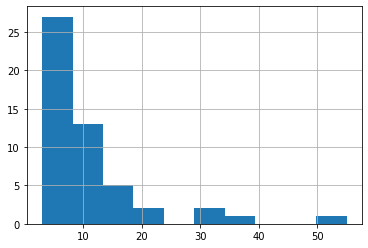

In [22]:
db_president_state.electoral_votes.hist()

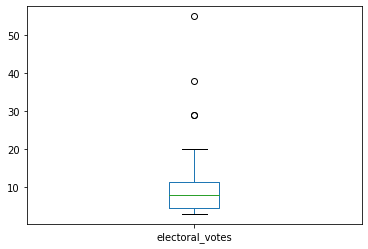

In [23]:
#TODO plotar o mapa dos EUA indicando o "peso" de cada estado com cores
db_president_state.electoral_votes.plot(kind="box")

O dataset **president_county.csv** descreve a quantidade de votos por estado, **state**, e condado, **county**. Representa a quantidade total de votos por condado na coluna **total_votes** e a quantidade atual de votos já computados na coluna **current_votes**, bem como a porcentagem de votos apurados em relação ao total na coluna **percent**.

In [9]:
db_president_county = pd.read_csv('us_elections/president_county.csv')
db_president_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4633 entries, 0 to 4632
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   state          4633 non-null   object
 1   county         4633 non-null   object
 2   current_votes  4633 non-null   int64 
 3   total_votes    4633 non-null   int64 
 4   percent        4633 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 181.1+ KB


Esse dataset possui três colunas numéricas, **total_votes**, **current_votes**  e **percent**. Porém, também apresentou inconsistências, pois, a quantidade de votos computados foi maior do que a quantidade total de votos em alguns condados:

In [10]:
db_inconsistent_president_county = db_president_county[db_president_county.apply(lambda row: row['current_votes'] > row['total_votes'], axis=1)].sort_values('percent', ascending=False)
inconsistency = db_inconsistent_president_county.county.count() / db_president_county.county.count()
print('Em ' + str(round(100*inconsistency,2)) + '% dos condados a quantidade atual de votos é maior que o total')

Em 35.23% dos condados a quantidade atual de votos é maior que o total


In [11]:
#TODO projetar até quanto esse valor pode crescer até o final da eleição

Para simplificar a análise, quando o valor de **current_votes** for maior uqe  **total_votes**, iremos modificar o total para ser igual ao valor corrente, caso contrário, não será possível estimar o vencedor da eleição.

In [24]:
db_president_state_votes = db_president_county.groupby('state').sum().reset_index()
db_president_state_votes.total_votes = db_president_state_votes.apply(lambda row: row['total_votes'] if row['total_votes'] > row['current_votes'] else row['current_votes'], axis=1)
db_president_state_votes.percent = db_president_state_votes.apply(lambda row: 100 * row['current_votes'] / row['total_votes'], axis=1)
db_president_state_votes.head()

,state,current_votes,total_votes,percent
0,Alabama,2309900,2309900,100.000000
1,Alaska,131885,366006,36.033562
2,Arizona,3322535,3403744,97.614127
3,Arkansas,1216818,1250053,97.341313
4,California,14414296,15813337,91.152778


Precisamos adicionar a coluna **remaining_votes** ao dataset para podermos verificar se ainda há chance do segundo colocado alcançar a maioria dos votos nos estados em que o primeiro colocado ainda não atingiu 50% ou mais de votos.

In [26]:
db_president_state_votes['remaining_votes'] = db_president_state_votes.total_votes - db_president_state_votes.current_votes
db_president_state_votes.sort_values('percent').head(5)

,state,current_votes,total_votes,percent,remaining_votes
1,Alaska,131885,366006,36.033562,234121
32,New York,6641544,8904800,74.583865,2263256
8,District of Columbia,279152,348619,80.073662,69467
30,New Jersey,3610021,4349127,83.005647,739106
20,Maryland,2497959,3002298,83.201568,504339


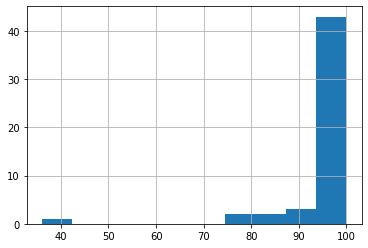

In [27]:
db_president_state_votes.percent.hist()

O dataset **president_county_candidate.csv** possui 4 colunas categóricas e 1 coluna numérica. São elas: o estado, **state**; o condado, **county**; o candidato, **candidate**; o partido ao qual ele está filiado, **party**; e a quantidade de votos que o candidato já recebeu naquele condado, **votes**.

In [28]:
db_president_county_candidate = pd.read_csv('us_elections/president_county_candidate.csv')
db_president_county_candidate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31167 entries, 0 to 31166
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      31167 non-null  object
 1   county     31167 non-null  object
 2   candidate  31167 non-null  object
 3   party      31167 non-null  object
 4   votes      31167 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


A distribuição de partidos por condado onde obtiveram pelo menos 1 voto para seu candidato se assemelha a uma distribuição exponencial.

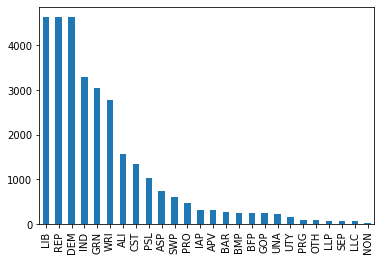

In [29]:
db_president_county_candidate.party.value_counts().plot(kind='bar')

## Preparação dos dados

### Calculando o total de votos computados por Candidato em cada Estado

In [30]:
# totalizando os votos por estado e candidato, já em ordem descrescente pela quantidade de votos
db_president_state_candidate = db_president_county_candidate.groupby(['state', 'candidate', 'party']).sum('votes').sort_values(by = ['state', 'votes'], ascending = [True, False]).reset_index()
db_president_state_candidate.head(4)

,state,candidate,party,votes
0,Alabama,Donald Trump,REP,1434159
1,Alabama,Joe Biden,DEM,843473
2,Alabama,Jo Jorgensen,LIB,24994
3,Alabama,Write-ins,WRI,7274


In [31]:
# define primeiro mais votado em cada Estado
db_1st_place_by_state = db_president_state_candidate.groupby('state').nth(0).reset_index()
db_1st_place_by_state.columns = ['state', '1st_candidate', '1st_party', '1st_votes']
db_1st_place_by_state.head()

,state,1st_candidate,1st_party,1st_votes
0,Alabama,Donald Trump,REP,1434159
1,Alaska,Donald Trump,REP,80999
2,Arizona,Joe Biden,DEM,1643664
3,Arkansas,Donald Trump,REP,761251
4,California,Joe Biden,DEM,9315259


In [33]:
# combina com o dataset de resultados
db_1st_results = pd.merge(db_president_state_votes, db_1st_place_by_state , how='left', on='state', )
db_1st_results['1st_percent'] = 100* db_1st_results['1st_votes'] / db_1st_results.current_votes
db_1st_results.head()

,state,current_votes,total_votes,percent,remaining_votes,1st_candidate,1st_party,1st_votes,1st_percent
0,Alabama,2309900,2309900,100.000000,0,Donald Trump,REP,1434159,62.087493
1,Alaska,131885,366006,36.033562,234121,Donald Trump,REP,80999,61.416385
2,Arizona,3322535,3403744,97.614127,81209,Joe Biden,DEM,1643664,49.470179
3,Arkansas,1216818,1250053,97.341313,33235,Donald Trump,REP,761251,62.560794
4,California,14414296,15813337,91.152778,1399041,Joe Biden,DEM,9315259,64.625140


In [34]:
# define o segundo mais votado em cada Estado
db_2nd_place_by_state = db_president_state_candidate.groupby('state').nth(1).reset_index()
db_2nd_place_by_state.columns = ['state', '2nd_candidate', '2nd_party', '2nd_votes']
db_2nd_place_by_state.head()

,state,2nd_candidate,2nd_party,2nd_votes
0,Alabama,Joe Biden,DEM,843473
1,Alaska,Joe Biden,DEM,45758
2,Arizona,Donald Trump,REP,1626679
3,Arkansas,Joe Biden,DEM,420985
4,California,Donald Trump,REP,4812735


In [35]:
# combina com o dataset de resultados
db_results_by_state = pd.merge(db_1st_results, db_2nd_place_by_state , how='left', on='state', )
db_results_by_state['2nd_percent'] = 100* db_results_by_state['2nd_votes'] / db_results_by_state.current_votes
db_results_by_state.head()

,state,current_votes,total_votes,percent,remaining_votes,1st_candidate,1st_party,1st_votes,1st_percent,2nd_candidate,2nd_party,2nd_votes,2nd_percent
0,Alabama,2309900,2309900,100.000000,0,Donald Trump,REP,1434159,62.087493,Joe Biden,DEM,843473,36.515563
1,Alaska,131885,366006,36.033562,234121,Donald Trump,REP,80999,61.416385,Joe Biden,DEM,45758,34.695379
2,Arizona,3322535,3403744,97.614127,81209,Joe Biden,DEM,1643664,49.470179,Donald Trump,REP,1626679,48.958973
3,Arkansas,1216818,1250053,97.341313,33235,Donald Trump,REP,761251,62.560794,Joe Biden,DEM,420985,34.597204
4,California,14414296,15813337,91.152778,1399041,Joe Biden,DEM,9315259,64.625140,Donald Trump,REP,4812735,33.388623


Consolidando todos os dados de interesse em um único dataframe de resultados a nível estadual

In [36]:
# calcula se o 2o colocado ainda tem chances de passar o 1o colocado
db_results_by_state['is_election_defined'] = db_results_by_state.apply(lambda row: True if (row['2nd_votes'] + row['remaining_votes'] < row['1st_votes']) else False, axis=1)
db_results_by_state[db_results_by_state['is_election_defined'].eq(False)]


,state,current_votes,total_votes,percent,remaining_votes,1st_candidate,1st_party,1st_votes,1st_percent,2nd_candidate,2nd_party,2nd_votes,2nd_percent,is_election_defined
1,Alaska,131885,366006,36.033562,234121,Donald Trump,REP,80999,61.416385,Joe Biden,DEM,45758,34.695379,False
2,Arizona,3322535,3403744,97.614127,81209,Joe Biden,DEM,1643664,49.470179,Donald Trump,REP,1626679,48.958973,False
28,Nevada,1323719,1400801,94.497291,77082,Joe Biden,DEM,664162,50.173942,Donald Trump,REP,629879,47.584042,False
30,New Jersey,3610021,4349127,83.005647,739106,Joe Biden,DEM,2108110,58.396059,Donald Trump,REP,1449928,40.163977,False
32,New York,6641544,8904800,74.583865,2263256,Joe Biden,DEM,3699332,55.699879,Donald Trump,REP,2850352,42.917008,False
33,North Carolina,5464097,5652431,96.668088,188334,Donald Trump,REP,2733687,50.029987,Joe Biden,DEM,2658280,48.649942,False
38,Pennsylvania,6765139,6827967,99.079843,62828,Joe Biden,DEM,3361668,49.691041,Donald Trump,REP,3315998,49.015963,False


In [48]:
db_president_state_results = pd.merge(db_president_state, db_results_by_state)
db_president_state_results.to_csv('us_elections/president_state_results.csv')
db_president_state_results.head()

,state,votes,electoral_votes,party,population,current_votes,total_votes,percent,remaining_votes,1st_candidate,1st_party,1st_votes,1st_percent,2nd_candidate,2nd_party,2nd_votes,2nd_percent,is_election_defined
0,Alabama,2309900,9,REP,4908621,2309900,2309900,100.000000,0,Donald Trump,REP,1434159,62.087493,Joe Biden,DEM,843473,36.515563,True
1,Alaska,172031,3,REP,734002,131885,366006,36.033562,234121,Donald Trump,REP,80999,61.416385,Joe Biden,DEM,45758,34.695379,False
2,Arizona,3322535,11,REP,7378494,3322535,3403744,97.614127,81209,Joe Biden,DEM,1643664,49.470179,Donald Trump,REP,1626679,48.958973,False
3,Arkansas,1216818,6,REP,3038999,1216818,1250053,97.341313,33235,Donald Trump,REP,761251,62.560794,Joe Biden,DEM,420985,34.597204,True
4,California,14414296,55,DEM,39937489,14414296,15813337,91.152778,1399041,Joe Biden,DEM,9315259,64.625140,Donald Trump,REP,4812735,33.388623,True


### Calculando o total de votos por Candidato (nível nacional)

In [43]:
# tabela de totais da votação
db_totals = pd.merge(db_president_state, db_president_state_votes, how="inner").sum()[['current_votes', 'total_votes', 'remaining_votes', 'electoral_votes']]
db_totals['percent'] = 100 * db_totals.current_votes / db_totals.total_votes
db_totals

current_votes      150361237
total_votes        158725744
remaining_votes      8364507
electoral_votes          538
percent              94.7302
dtype: object

In [44]:
# total geral de votos computados para cada candidato
db_president_candidate = db_president_state_candidate.groupby(['candidate', 'party']).sum().sort_values('votes', ascending=False).reset_index()
db_president_candidate.columns = ['candidate', 'party', 'total_candidate_votes']
db_president_candidate.head(5)

,candidate,party,total_candidate_votes
0,Joe Biden,DEM,76193955
1,Donald Trump,REP,71500110
2,Jo Jorgensen,LIB,1756245
3,Howie Hawkins,GRN,358496
4,Write-ins,WRI,160572


In [46]:
# resultado estimado do somatório do voto dos delegados nos estados onde o resultado da votação já está definido
db_electoral_results = db_president_state_results[db_president_state_results.is_election_defined].groupby(['1st_candidate', '1st_party']).sum().sort_values('electoral_votes', ascending=False).reset_index()[['1st_candidate', '1st_party', 'electoral_votes']]
db_electoral_results.columns = ['candidate', 'party', 'candidate_electoral_votes']
db_electoral_results

,candidate,party,candidate_electoral_votes
0,Joe Biden,DEM,226
1,Donald Trump,REP,214


In [47]:
db_results = pd.merge(db_electoral_results, db_president_candidate, how='inner')
db_results['votes_percent'] = 100 * db_results.total_candidate_votes / db_totals.current_votes
db_results['electoral_percent'] = 100 * db_results.candidate_electoral_votes / db_totals.electoral_votes
db_results

,candidate,party,candidate_electoral_votes,total_candidate_votes,votes_percent,electoral_percent
0,Joe Biden,DEM,226,76193955,50.673935,42.007435
1,Donald Trump,REP,214,71500110,47.552223,39.776952


In [28]:
#TODO considerar que a quantidade de votos dos delegados em Maine e Nebraska pode estar errada, pois não temos dados dos Distritos Eleitorais, totalizando um erro entre -5 e +5 votos de delegados

In [29]:
#TODO calcular a chance de Biden ser o novo presidente

In [30]:
#TODO calcular a chance de Trump ser o novo presidente

# Lelson

### Intervalo de Confiança do Percentual de Apuração ao nível de 95%

In [31]:
# Pacote necessário
from scipy.stats import t,norm

In [32]:
db_results_by_state['percent'].mean()

95.16680097173028

In [33]:
# a) Intervalo de Confiança do Percentual de Apuração ao nível de 95%;
print("Intervalo de Confiança do percentual de apuração ao nível de 95% ")
inf,sup = t.interval(0.95, db_results_by_state['percent'].count()-1, loc=db_results_by_state['percent'].mean(), scale= st.stdev(db_results_by_state['percent'])/np.sqrt(db_results_by_state['percent'].count()))
print ('Limite inferior 95%:', round(inf,3))
print ('Limite superior 95%:', round(sup,3))

Intervalo de Confiança do percentual de apuração ao nível de 95% 
Limite inferior 95%: 92.342
Limite superior 95%: 97.992


### Intervalo de Confiança do Percentual do Primeiro colocado em média ao nível de 95%

In [35]:
print("Intervalo de Confiança do Percentual do Primeiro colocado ao nível de 95% ")
inf,sup = t.interval(0.95, db_results_by_state['1st_percent'].count()-1, loc=db_results_by_state['1st_percent'].mean(), scale= st.stdev(db_results_by_state['1st_percent'])/np.sqrt(db_results_by_state['1st_percent'].count()))
print ('Limite inferior 95%:', round(inf,3))
print ('Limite superior 95%:', round(sup,3))

Intervalo de Confiança do Percentual do Primeiro colocado ao nível de 95% 
Limite inferior 95%: 56.389
Limite superior 95%: 60.465


### Intervalo de Confiança do Percentual do Segundo colocado  em média ao nível de 95%;

In [36]:
print("Intervalo de Confiança do Percentual do Segundo colocado ao nível de 95% ")
inf,sup = t.interval(0.95, db_results_by_state['2nd_percent'].count()-1, loc=db_results_by_state['2nd_percent'].mean(), scale= st.stdev(db_results_by_state['2nd_percent'])/np.sqrt(db_results_by_state['2nd_percent'].count()))
print ('Limite inferior 95%:', round(inf,3))
print ('Limite superior 95%:', round(sup,3))

Intervalo de Confiança do Percentual do Segundo colocado ao nível de 95% 
Limite inferior 95%: 37.352
Limite superior 95%: 41.579


In [37]:
db_president_county.head(10)

,state,county,current_votes,total_votes,percent
0,Delaware,Kent County,86958,88000,95
1,Delaware,New Castle County,286133,293878,95
2,Delaware,Sussex County,129293,125000,95
3,District of Columbia,District of Columbia,31260,45392,69
4,District of Columbia,Ward 2,27259,37140,73
5,District of Columbia,Ward 3,37377,47692,78
6,District of Columbia,Ward 4,37223,45917,81
7,District of Columbia,Ward 5,38778,44719,87
8,District of Columbia,Ward 6,49394,57889,85
9,District of Columbia,Ward 7,31823,37287,85


### Intervalo de confiança das médias percentuais dos condados e uma análise de possibilidade de vitória do Byden com base em média ponderada


Nesta análise tentaremos avaliar as chances do candidato Byden confirmar a vitória com base na manutenção dos delegados referentes aos estados nos quais ele está ganhando. 

Nesta situação, avaliaremos os votos que faltam ser contados nos condados dos estados pendentes em favor de Byden.

Para isso, em cada estado é feita uma média ponderada dos votos restantes em relação ao percentual de votos obtidas pelo candidato Byden naquele condado. É importante observar que, mesmo em estados dominados por um partido, o outro partido consegue vitórias expressivas em determinados condados. Assim, a ponderação por condados foi adotada para cálculo da possibilidade de vitória em cada cada estado.


In [39]:
# filtra os estados sem vencedor definido, com o candidato Byden na frente (Arizona, Nevada, New Jersey, New York, Pennsylvania)
estados_pendentes = db_results_by_state[db_results_by_state['is_election_defined'].eq(False)]
estados_pendentes = estados_pendentes[estados_pendentes['1st_candidate'].eq('Joe Biden')]
# Para cada um dos 5 estados é feito o mesmo processo
for estado in estados_pendentes['state']:
  print("  ")
  print("----------------------- ")
  print("ESTADO: ",estado)
  lista_perc = []
  lista_tot = []

  # recupera os dados do estado
  dados_estado = db_results_by_state[db_results_by_state['state'] == estado]
  total_votos = int(dados_estado['remaining_votes'])

  # filtra os condados deste estado
  dados_condado = db_president_county[db_president_county['state'] == estado]

  # zera o total de votos projetados para o Byden no estado
  total_votos_projetados = 0.0
  percentual_final = 0.0

  # Para cada condado, verifica os votos que faltam e 
  # qual o percentual de votos do Byden confirmados até ali
  # projeta o percentual do Byden até final com base na manutenção dos percentuais atuais
  for condado in dados_condado['county']:
    # seleciona o condado
    db_condado = dados_condado[dados_condado['county'] == condado]

    # votos restantes no condado
    votos_restantes = int(db_condado['total_votes']) - int(db_condado['current_votes'])

    # verifica o total de votos do Byden no condado e total que falta apurar
    db_condado_estado = db_president_county_candidate[db_president_county_candidate['state'] == estado]
    db_condado_estado = db_condado_estado[db_condado_estado['county'] == condado]
    db_byden_condado = db_condado_estado[db_condado_estado['candidate'] == 'Joe Biden']

    #calcula o percentual do Byden
    tvotos = int(db_byden_condado['votes'])
    cvotos = int(db_condado['current_votes'])
    percentual_byden = 0.0 + (tvotos / cvotos)

    # votos projetados 
    votos_projetados = votos_restantes * percentual_byden

    # separa os percentuais individuais dos condados
    if votos_restantes > 0:
      lista_perc.append(percentual_byden * 100)
      lista_tot.append(votos_restantes)
    #totaliza os votos projetados para o Byden no estado
    total_votos_projetados = total_votos_projetados + votos_projetados
  
  #calcula o percentual de votos do Byden em relação ao total que falta
  percentual_final = total_votos_projetados / total_votos
  print('Percentual que o Biden teria dos votos restantes: ' + str(round(((total_votos_projetados / total_votos) * 100) , 2)))

  # ###########
  # Cálculo da média dos percentuais de votação do Byden nos condados 
  print("  ")
  print("Média dos pencentuais previstos pro Byden nos condados que faltam: " + str(st.mean(lista_perc)))

  # Cálculo dos intervalos de confiança 
  print("Intervalo de Confiança do percentual previsto ao nível de 95% ")
  tam_lista = len(lista_perc)
  inf,sup = t.interval(0.95, tam_lista - 1, loc=st.mean(lista_perc), scale= st.stdev(lista_perc)/np.sqrt(tam_lista))
  print ('   Limite inferior 95%:', round(inf,3))
  print ('   Limite superior 95%:', round(sup,3))
  print ('Quantidade de condados:', len(lista_perc))
  print(" Percentuais dos condados ")
  print (lista_perc)
  print (lista_tot)
  # #############
    

  
----------------------- 
ESTADO:  Arizona
Percentual que o Biden teria dos votos restantes: 49.89
  
Média dos pencentuais previstos pro Byden nos condados que faltam: 42.174081326702215
Intervalo de Confiança do percentual previsto ao nível de 95% 
   Limite inferior 95%: 34.467
   Limite superior 95%: 49.881
Quantidade de condados: 14
 Percentuais dos condados 
[45.17316898269279, 58.88519891908721, 40.4922307943062, 67.20790862060134, 34.72288015158693, 46.12506759027869, 40.527334746934635, 61.066383108005475, 32.33188720173536, 26.905889415060365, 32.07598371777476, 30.730025483435767, 50.38517150996257, 23.80800833236894]
[1103, 25936, 5900, 77, 2563, 2105, 6765, 1587, 113, 2, 5, 829, 33168, 2308]
  
----------------------- 
ESTADO:  Nevada
Percentual que o Biden teria dos votos restantes: 50.74
  
Média dos pencentuais previstos pro Byden nos condados que faltam: 28.861797390249233
Intervalo de Confiança do percentual previsto ao nível de 95% 
   Limite inferior 95%: 22.472
 